"The existence of momentum is a well-established empirical fact. The return premium is evident in 212 years of U.S. equity data (from 1801 to 2012) — as well as U.K. equity data dating back to the Victorian age in over 20 years of out-of-sample evidence from its original discovery, in 40 other countries and in more than a dozen other asset classes." Asness, Frazzini & Moskowitz, Journal of Portfolio Management.

Here we build an equal weight portfolio with the 10 best performing stocks of the S&P500 index in 2023. We then compare the portfolio's performance over 2024 to that of the whole index.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# Get S&P 500 tickers 
sp500_url = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tickers = pd.read_html(sp500_url)[0]['Symbol'].tolist()

In [3]:
# Downloading data for each stock of the S&P
def download_data_in_chunks(tickers, start_date, end_date, chunk_size=50): # Formula to bypass yfinance's rate limit
    data = {}
    for i in range(0, len(tickers), chunk_size):
        chunk = tickers[i:i + chunk_size]
        chunk_data = yf.download(chunk, start=start_date, end=end_date, group_by='ticker')
        for ticker in chunk:
            if ticker in chunk_data:
                data[ticker] = chunk_data[ticker]['Close']
        time.sleep(2)  # Add a delay to avoid rate limiting
    return pd.DataFrame(data)

In [4]:
# Download 2023 data for all S&P 500 stocks 
data_2023 = download_data_in_chunks(tickers, start_date="2023-01-03", end_date="2023-12-29")

# Calculate annual returns for each stock in 2023
annual_returns_2023 = {}
for ticker in data_2023.columns:
    returns = data_2023[ticker].pct_change().dropna()  # Daily returns
    annual_returns_2023[ticker] = (1 + returns).prod() - 1  # Annualized returns

# Convert to a Series and sort by annual returns
annual_returns_2023 = pd.Series(annual_returns_2023)
annual_returns_2023 = annual_returns_2023.sort_values(ascending=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-03 -> 2023-12-29)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed

1 Failed download:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-03 -> 2023-12-29) (Yahoo error = "Data doesn\'t exist for startDate = 1672722000, endDate = 1703826000")')
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***

In [22]:
# Pick the top 10 performing stocks
top_10_tickers = annual_returns_2023.head(10).index.tolist()

# Print the top 10 tickers and their annual returns
print("\nTop 10 Performing Stocks of 2023:")
formatted_2023 = annual_returns_2023[top_10_tickers].map("{:.2%}".format)
print(formatted_2023.to_string())


Top 10 Performing Stocks of 2023:
SMCI    247.54%
NVDA    246.10%
META    187.25%
PLTR    174.80%
RCL     166.82%
BLDR    158.09%
UBER    148.97%
CRWD    148.00%
CCL     134.25%
TSLA    134.21%


In [12]:
# Define time period for 2024
start_date = '2024-01-01'
end_date = '2024-12-31'

# Download 2024 data for the top 10 stocks
stock_data = yf.download(top_10_tickers, start=start_date, end=end_date, group_by='ticker')

# Extract Close prices for each stock
close_data = pd.DataFrame()
for ticker in top_10_tickers:
    close_data[ticker] = stock_data[ticker]['Close']

# Download S&P 500 data 
sp500 = yf.download('SPY', start=start_date, end=end_date)['Close']

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
# Calculate daily returns for the stocks and portfolio
stock_returns = close_data.pct_change().dropna()
portfolio_returns = stock_returns.mean(axis=1)  # Equal-weighted portfolio

# Calculate cumulative returns
cumulative_portfolio = (1 + portfolio_returns).cumprod() - 1
cumulative_sp500 = (1 + sp500.pct_change().dropna()).cumprod() - 1

/var/folders/js/kyfc03vx5v387xfwqk_l_7z40000gn/T/ipykernel_40566/1780940186.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_return_sp500 = float(cumulative_sp500.iloc[-1]) * 100


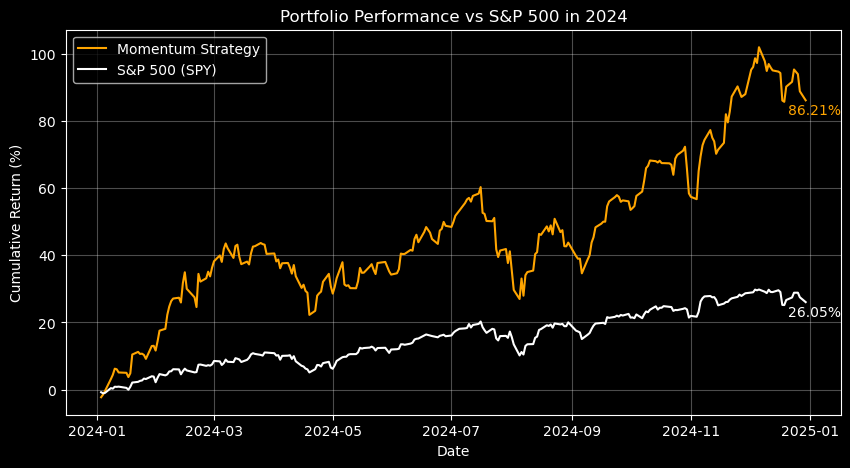

In [21]:
# Plotting
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(cumulative_portfolio.index, cumulative_portfolio * 100, label='Momentum Strategy', color="orange")
plt.plot(cumulative_sp500.index, cumulative_sp500 * 100, label='S&P 500 (SPY)', color="white")

# Final cumulative returns as text on plot
last_return_portfolio = float(cumulative_portfolio.iloc[-1]) * 100
plt.annotate(
    f'{last_return_portfolio:.2f}%', 
    xy=(cumulative_portfolio.index[-1], last_return_portfolio),
    xytext=(35, -10),  # 30 pixels to the left
    textcoords='offset pixels',
    color='orange',
    ha='right',  # Align right since we're moving left
    va='center'
)
last_return_sp500 = float(cumulative_sp500.iloc[-1]) * 100
plt.annotate(
    f'{last_return_sp500:.2f}%', 
    xy=(cumulative_sp500.index[-1], last_return_sp500),
    xytext=(35, -10),  # Same 30px left offset
    textcoords='offset pixels',
    color='white',
    ha='right',
    va='center'
)

plt.title('Portfolio Performance vs S&P 500 in 2024')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=.3, zorder=0)
plt.show()

In [24]:
# Calculate 2024 performance for each top stock
top_10_2024_returns = {}
for ticker in top_10_tickers:
    if ticker in close_data:
        returns = close_data[ticker].pct_change().dropna()
        cumulative_return = (1 + returns).prod() - 1
        top_10_2024_returns[ticker] = cumulative_return

# Convert to Series and format as percentages
top_10_2024_returns = pd.Series(top_10_2024_returns)
top_10_2024_returns = top_10_2024_returns.sort_values(ascending=False)

# Print 2024 performance with percentage formatting
print("\n2024 Performance of Momentum Stocks:")
formatted_2024 = top_10_2024_returns.map("{:.2%}".format)
print(formatted_2024.to_string())


2024 Performance of Momentum Stocks:
PLTR    365.50%
NVDA    185.52%
RCL      94.64%
META     71.39%
TSLA     68.03%
CCL      44.88%
CRWD     41.48%
SMCI      7.48%
UBER      4.09%
BLDR    -13.31%


The period of testing of the strategy is too small for any real insight to be derived from it, the extreme cumulative returns are due to market conditions and extreme growth of a few stocks.

On average, excess returns over a longer period would be significantly smaller.